In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from collections import deque 
from tensorflow.keras import layers
import time 
import scipy.io as sio

from vehicle_model_variant import Environment_DDPG 
from vehicle_model_ECMS import Environment_ECMS  
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
driver = Driver_MDP(0.02) 

num_states = 4 

In [3]:
def get_best_EF(env, EF_temp, threshold): 
    histories = {} 
    while True: 
        print(EF_temp)
        history = env.PMP_calculation(EF_temp)
        histories[EF_temp] = history 

        SOC_final = history["SOC_traj"][-1]
        fuel_consumption = np.sum(history["fc_traj"])
        print("Equivalent factor: {:.2f}, Final SOC: {:.4f}, fuel_consumption: {:.4f}".
              format(EF_temp, SOC_final, fuel_consumption))

        if abs(SOC_final - 0.6) < threshold: 
            break 

        EF_temp += 5 * (SOC_final - 0.6)

    return EF_temp, histories 

In [4]:

driving_cycle = driver.get_cycle() 
env = Environment_ECMS(cell_model, driving_cycle, battery_path, motor_path, False)

EF_opt, histories = get_best_EF(env, -45, 0.01)

-45


C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\model_validation\vehicle_model_ECMS.py:196: RuntimeWarning: invalid value encountered in sqrt
  del_is = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * battery_powers) ** (0.5)) * (battery_powers < 0) \
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\model_validation\vehicle_model_ECMS.py:197: RuntimeWarning: invalid value encountered in sqrt
  + (1 / (2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * battery_powers) ** (0.5)) * (battery_powers >= 0)
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\model_validation\vehicle_model_ECMS.py:199: RuntimeWarning: invalid value encountered in greater
  del_SOCs[((i_lim_dis - del_is) * (i_lim_cha - del_is)) > 0] = np.nan


There is invalid actions..
Equivalent factor: -45.00, Final SOC: 0.3564, fuel_consumption: 1.6297
-46.21821529437907
There is invalid actions..
Equivalent factor: -46.22, Final SOC: 0.3564, fuel_consumption: 1.6297
-47.43643058875814
There is invalid actions..
Equivalent factor: -47.44, Final SOC: 0.3564, fuel_consumption: 1.6297
-48.65464588313721
There is invalid actions..
Equivalent factor: -48.65, Final SOC: 0.3591, fuel_consumption: 1.7616
-49.85897745669508
There is invalid actions..
Equivalent factor: -49.86, Final SOC: 0.3645, fuel_consumption: 2.0256
-51.036230761593316
There is invalid actions..
Equivalent factor: -51.04, Final SOC: 0.3663, fuel_consumption: 2.1135
-52.20464818081614
There is invalid actions..
Equivalent factor: -52.20, Final SOC: 0.3681, fuel_consumption: 2.2015
-53.36436349414051
There is invalid actions..
Equivalent factor: -53.36, Final SOC: 0.3698, fuel_consumption: 2.2895
-54.515558230378566
There is invalid actions..
Equivalent factor: -54.52, Final SO

# Visualization Shooting method 

In [ ]:
fig = plt.figure(figsize=(20, 6))
cmap = plt.get_cmap('jet')
norm = mpl.colors.Normalize(vmin=30, vmax=80)

plt.subplot(1, 2, 1)
plt.plot(np.array(driving_cycle) * 3.6, linewidth=2, )
plt.xlabel("Time[s]", fontsize=16)
plt.ylabel("Velocity[km/h]", fontsize=16)
plt.title("Cycle from MDP driver", fontsize=16)
plt.grid() 

plt.subplot(1, 2, 2)
for EF, history in histories.items():
    color = cmap(EF / -80)
    if EF == EF_opt: 
        plt.plot(history["SOC_traj"], linewidth=3, c=color, label="SOC trajectory*@co-state={:.2f}".
                 format(EF))
    else: 
        plt.plot(history["SOC_traj"], c=color)

plt.legend(fontsize=14) 
plt.ylabel("SOC", fontsize=16)
plt.xlabel("Time [s]", fontsize=16)
plt.title("SOC Trajectories with co-state", fontsize=16)
plt.grid() 
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.savefig("ECMS Shooting MDP Cycle.png")


In [5]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    
    
actor_model = get_actor() 

In [6]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [7]:
def test_model(cycle, model_path, EF, fig_title): 
#     test_cycle = driver.get_cycle() 
    env_ECMS = Environment_ECMS(cell_model, cycle, battery_path, motor_path, False)
    history_ECMS = env_ECMS.PMP_calculation(EF)
#     print(history_ECMS)
    
    env_DDPG = Environment_DDPG(cell_model, cycle, battery_path, motor_path, 10, False) 
    actor_model.load_weights(model_path)
    
    total_reward = 0 
    state = env_DDPG.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env_DDPG.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
#     SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    history_DDPG = env_DDPG.history 
    print("******************* Test is start *****************")
#     print(test_cycle)
#     print(history_ECMS["SOC_traj"][-1])
#     print(env_DDPG.fuel_consumption)
    final_SOC_ECMS = history_ECMS["SOC_traj"][-1]
    final_SOC_DDPG = history_DDPG["SOC"][-1] 
    FC_ECMS = np.sum(history_ECMS["fc_traj"])
    FC_DDPG = env_DDPG.fuel_consumption
    EQFC_ECMS = (0.6 - final_SOC_ECMS) * 71.8 + FC_ECMS 
    EQFC_DDPG = (0.6 - final_SOC_DDPG) * 71.8 + FC_DDPG
    print("final SOC for ECMS: {:.4f}, final SOC for DDPG: {:.4f}".format(
        final_SOC_ECMS, final_SOC_DDPG))
    print("FC for ECMS: {:.4f}, FC for DDPG: {:.4f}".format(FC_ECMS, FC_DDPG))
    print("EQFC for ECMS: {:.4f}, EQFC for DDPG: {:.4f}".format(EQFC_ECMS, EQFC_DDPG))
    print("******************* Test is done *****************")
    print("")
    
    
    
    plt.figure(figsize=(10, 6))
    
#     plt.subplot(2, 1, 1)
#     plt.plot(cycle * 3.6, linewidth=2, )
#     plt.ylabel("Velocity[km/h]", fontsize=16)
#     plt.grid() 
    
#     plt.subplot(2, 1, 2)
    plt.plot(history_ECMS["SOC_traj"], linewidth=2, label="SOC trajectory for ECMS") 
    plt.plot(history_DDPG["SOC"], linewidth=2, label="SOC trajectory for DDPG")
    
    plt.grid() 
    plt.xlabel("Time[s]", fontsize=16)
    plt.ylabel("SOC", fontsize=16)
    plt.legend(fontsize=14)
    plt.savefig("{}.png".format(fig_title))
    return history_DDPG 

In [ ]:
training_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'

test_cycles = [
    "../data/driving_cycles/all/00_nedc.mat", 
    "../data/driving_cycles/all/cudec_freeway.mat",
]

all_cycles = glob.glob("../data")

driving_cycle = sio.loadmat(training_cycle)
driving_cycle = sio.loadmat(test_cycles[0])
driving_cycle = driving_cycle["sch_cycle"][:, 1]

actor = "./DDPG_referenc_all_transferLearning/actor_model.h5" 
# actor = "./DDPG_MDP_mass1200/actor_model.h5" 
history = test_model(driving_cycle, actor, EF_opt, "comparison_on_MDP")

In [8]:
def test_model_ver2(cycle, model_path, EF): 
#     test_cycle = driver.get_cycle() 
    env_ECMS = Environment_ECMS(cell_model, cycle, battery_path, motor_path, False)
    history_ECMS = env_ECMS.PMP_calculation(EF)
#     print(history_ECMS)
    
    env_DDPG = Environment_DDPG(cell_model, cycle, battery_path, motor_path, 10, False) 
    actor_model.load_weights(model_path)
    
    total_reward = 0 
    state = env_DDPG.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env_DDPG.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
#     SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    history_DDPG = env_DDPG.history 
    
    if len(history_DDPG["SOC"]) == len(history_ECMS["SOC_traj"]): 
        print("******************* Test is start *****************")
    #     print(test_cycle)
    #     print(history_ECMS["SOC_traj"][-1])
    #     print(env_DDPG.fuel_consumption)
        final_SOC_ECMS = history_ECMS["SOC_traj"][-1]
        final_SOC_DDPG = history_DDPG["SOC"][-1] 
        FC_ECMS = np.sum(history_ECMS["fc_traj"])
        FC_DDPG = env_DDPG.fuel_consumption
        EQFC_ECMS = (0.6 - final_SOC_ECMS) * 71.8 + FC_ECMS 
        EQFC_DDPG = (0.6 - final_SOC_DDPG) * 71.8 + FC_DDPG
        print("final SOC for ECMS: {:.4f}, final SOC for DDPG: {:.4f}".format(
            final_SOC_ECMS, final_SOC_DDPG))
        print("FC for ECMS: {:.4f}, FC for DDPG: {:.4f}".format(FC_ECMS, FC_DDPG))
        print("EQFC for ECMS: {:.4f}, EQFC for DDPG: {:.4f}".format(EQFC_ECMS, EQFC_DDPG))
        print("******************* Test is done *****************")
        print("")
        
        return EQFC_ECMS, EQFC_DDPG  
    
    else: 
        return None, None 

In [9]:
actor = "./DDPG_referenc_all_transferLearning/actor_model.h5" 

EQFC_ECMS_set = [] 
EQFC_DDPG_set = [] 
for iter in range(100): 
    print(iter)
    driving_cycle = driver.get_cycle() 
    env = Environment_ECMS(cell_model, driving_cycle, battery_path, motor_path, False)
    EF_opt, histories = get_best_EF(env, -45, 0.01)
    
    EQFC_ECMS, EQFC_DDPG = test_model_ver2(driving_cycle, actor, EF_opt)
    if EQFC_ECMS is not None and EQFC_DDPG is not None:  
        EQFC_ECMS_set.append(EQFC_ECMS)
        EQFC_DDPG_set.append(EQFC_DDPG)


0
-45
There is invalid actions..
Equivalent factor: -45.00, Final SOC: 0.0686, fuel_consumption: 7.2621
-47.65694476731687
There is invalid actions..
Equivalent factor: -47.66, Final SOC: 0.0848, fuel_consumption: 7.9219
-50.23276132587466
There is invalid actions..
Equivalent factor: -50.23, Final SOC: 0.1038, fuel_consumption: 8.7576
-52.71359789526647
There is invalid actions..
Equivalent factor: -52.71, Final SOC: 0.1281, fuel_consumption: 9.9013
-55.072964460280254
There is invalid actions..
Equivalent factor: -55.07, Final SOC: 0.1553, fuel_consumption: 11.2650
-57.29661573701888
There is invalid actions..
Equivalent factor: -57.30, Final SOC: 0.1819, fuel_consumption: 12.6726
-59.38728335681539
There is invalid actions..
Equivalent factor: -59.39, Final SOC: 0.2103, fuel_consumption: 14.2561
-61.3355828282747
There is invalid actions..
Equivalent factor: -61.34, Final SOC: 0.2430, fuel_consumption: 16.1476
-63.12053853520455
There is invalid actions..
Equivalent factor: -63.12, 

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\model_validation\vehicle_model_variant.py:270: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\model_validation\vehicle_model_variant.py:271: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
1
-45
SOC is too low..
Equivalent factor: -45.00, Final SOC: 0.0037, fuel_consumption: 2.6010
-47.98160150103935
SOC is too low..
Equivalent factor: -47.98, Final SOC: 0.0048, fuel_consumption: 3.1730
-50.95745084863579
SOC is too low..
Equivalent factor: -50.96, Final SOC: 0.0045, fuel_consumption: 4.0529
-53.93476480230513
SOC is too low..
Equivalent factor: -53.93, Final SOC: 0.0044, fuel_consumption: 6.3845
-56.912896963297634
SOC is too low..
Equivalent factor: -56.91, Final SOC: 0.0045, fuel_consumption: 8.5843
-59.89060651465148
SOC is too low..
Equivalent factor: -59.89, Final SOC: 0.0049, fuel_consumption: 17.1632
-62.86586939022686
Equivalent factor: -62.87, Final SOC: 0.0222, fuel_consumption: 49.9827
-65.75477524909202
There is invalid actions..
Equivalent factor: -65.75, Final SOC: 0.1677, fuel_consumption: 51.6972
-67.91614747986058
There is invalid actions..
Equivalent factor: -67.92, Final SOC: 0.3472, fuel_consumption: 63.3100
-69

SOC is too low..
Equivalent factor: -45.00, Final SOC: 0.0040, fuel_consumption: 5.6362
-47.97978073341515
There is invalid actions..
Equivalent factor: -47.98, Final SOC: 0.1030, fuel_consumption: 3.6118
-50.46482518849915
There is invalid actions..
Equivalent factor: -50.46, Final SOC: 0.1097, fuel_consumption: 3.9197
-52.91610171608317
There is invalid actions..
Equivalent factor: -52.92, Final SOC: 0.1203, fuel_consumption: 4.4476
-55.31468220629551
There is invalid actions..
Equivalent factor: -55.31, Final SOC: 0.1371, fuel_consumption: 5.3273
-57.62913413224366
There is invalid actions..
Equivalent factor: -57.63, Final SOC: 0.1634, fuel_consumption: 6.7349
-59.81231733288656
There is invalid actions..
Equivalent factor: -59.81, Final SOC: 0.1836, fuel_consumption: 7.8786
-61.894196860022625
There is invalid actions..
Equivalent factor: -61.89, Final SOC: 0.2039, fuel_consumption: 9.0663
-63.874634330076155
There is invalid actions..
Equivalent factor: -63.87, Final SOC: 0.2401,

Equivalent factor: -67.73, Final SOC: 0.3369, fuel_consumption: 64.9826
-69.04539483031294
Equivalent factor: -69.05, Final SOC: 0.4363, fuel_consumption: 71.7127
-69.8639132137651
Equivalent factor: -69.86, Final SOC: 0.4891, fuel_consumption: 75.3637
-70.41839414353215
Equivalent factor: -70.42, Final SOC: 0.5394, fuel_consumption: 78.8828
-70.72160413943651
Equivalent factor: -70.72, Final SOC: 0.5637, fuel_consumption: 80.5983
-70.90307644671162
Equivalent factor: -70.90, Final SOC: 0.5749, fuel_consumption: 81.3901
-71.0286164627326
Equivalent factor: -71.03, Final SOC: 0.5836, fuel_consumption: 82.0059
-71.11074358072698
Equivalent factor: -71.11, Final SOC: 0.5898, fuel_consumption: 82.4458
-71.1619172552881
Equivalent factor: -71.16, Final SOC: 0.5935, fuel_consumption: 82.7097
maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for ECMS: 0.5935, final SOC for DDPG: 0.5813
FC for ECMS: 82.7097, FC for DDPG: 82.3011
EQFC for ECMS:

Equivalent factor: -65.73, Final SOC: 0.1505, fuel_consumption: 63.6190
-67.97996901512626
Equivalent factor: -67.98, Final SOC: 0.3452, fuel_consumption: 76.1115
-69.25392910174148
Equivalent factor: -69.25, Final SOC: 0.4301, fuel_consumption: 81.8739
-70.10333073039283
Equivalent factor: -70.10, Final SOC: 0.4955, fuel_consumption: 86.4047
-70.62567588700072
Equivalent factor: -70.63, Final SOC: 0.5363, fuel_consumption: 89.2639
-70.94426590464303
Equivalent factor: -70.94, Final SOC: 0.5600, fuel_consumption: 90.9354
-71.14450098168896
Equivalent factor: -71.14, Final SOC: 0.5717, fuel_consumption: 91.7712
-71.28585779991381
Equivalent factor: -71.29, Final SOC: 0.5835, fuel_consumption: 92.6070
-71.36844713668427
Equivalent factor: -71.37, Final SOC: 0.5958, fuel_consumption: 93.4867
maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for ECMS: 0.5958, final SOC for DDPG: 0.5761
FC for ECMS: 93.4867, FC for DDPG: 92.2560
EQFC for EC

Equivalent factor: -67.96, Final SOC: 0.3566, fuel_consumption: 71.0089
-69.17812737617635
Equivalent factor: -69.18, Final SOC: 0.4428, fuel_consumption: 76.8593
-69.96411334750438
Equivalent factor: -69.96, Final SOC: 0.5012, fuel_consumption: 80.9062
-70.45788763768087
Equivalent factor: -70.46, Final SOC: 0.5408, fuel_consumption: 83.6774
-70.75387370805375
Equivalent factor: -70.75, Final SOC: 0.5589, fuel_consumption: 84.9531
-70.95937197047161
Equivalent factor: -70.96, Final SOC: 0.5713, fuel_consumption: 85.8328
-71.10271724595546
Equivalent factor: -71.10, Final SOC: 0.5800, fuel_consumption: 86.4487
-71.20264263304566
Equivalent factor: -71.20, Final SOC: 0.5943, fuel_consumption: 87.4604
maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for ECMS: 0.5943, final SOC for DDPG: 0.5863
FC for ECMS: 87.4604, FC for DDPG: 87.2870
EQFC for ECMS: 87.8732, EQFC for DDPG: 88.2707
******************* Test is done *****************

17


SOC is too low..
Equivalent factor: -56.91, Final SOC: 0.0048, fuel_consumption: 8.5405
-59.88535527698213
SOC is too low..
Equivalent factor: -59.89, Final SOC: 0.0049, fuel_consumption: 16.7233
-62.8609399140615
Equivalent factor: -62.86, Final SOC: 0.0341, fuel_consumption: 49.0150
-65.69068276425075
Equivalent factor: -65.69, Final SOC: 0.1654, fuel_consumption: 56.9768
-67.8635391085732
Equivalent factor: -67.86, Final SOC: 0.3637, fuel_consumption: 69.7773
-69.04493065753779
Equivalent factor: -69.04, Final SOC: 0.4428, fuel_consumption: 75.1438
-69.83102771150482
Equivalent factor: -69.83, Final SOC: 0.4994, fuel_consumption: 79.0587
-70.33415602887624
Equivalent factor: -70.33, Final SOC: 0.5233, fuel_consumption: 80.7303
-70.71771685667711
Equivalent factor: -70.72, Final SOC: 0.5489, fuel_consumption: 82.5338
-70.97316345176725
Equivalent factor: -70.97, Final SOC: 0.5676, fuel_consumption: 83.8534
-71.13535602392376
Equivalent factor: -71.14, Final SOC: 0.5762, fuel_consumpt

Equivalent factor: -70.59, Final SOC: 0.5492, fuel_consumption: 80.3784
-70.84163097648053
Equivalent factor: -70.84, Final SOC: 0.5629, fuel_consumption: 81.3461
-71.02709802643149
Equivalent factor: -71.03, Final SOC: 0.5722, fuel_consumption: 82.0059
-71.16599600304349
Equivalent factor: -71.17, Final SOC: 0.5803, fuel_consumption: 82.5777
-71.26465270049368
Equivalent factor: -71.26, Final SOC: 0.5846, fuel_consumption: 82.8857
-71.34167088815411
Equivalent factor: -71.34, Final SOC: 0.5902, fuel_consumption: 83.2816
maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for ECMS: 0.5902, final SOC for DDPG: 0.5818
FC for ECMS: 83.2816, FC for DDPG: 83.1612
EQFC for ECMS: 83.9886, EQFC for DDPG: 84.4713
******************* Test is done *****************

24
-45
SOC is too low..
Equivalent factor: -45.00, Final SOC: 0.0048, fuel_consumption: 1.1497
-47.97580444915592
SOC is too low..
Equivalent factor: -47.98, Final SOC: 0.0046, fuel_con

There is invalid actions..
Equivalent factor: -70.32, Final SOC: 0.5385, fuel_consumption: 47.9098
-70.62745483184486
There is invalid actions..
Equivalent factor: -70.63, Final SOC: 0.5510, fuel_consumption: 48.7896
-70.87225618847806
There is invalid actions..
Equivalent factor: -70.87, Final SOC: 0.5598, fuel_consumption: 49.4054
-71.07346015869967
There is invalid actions..
Equivalent factor: -71.07, Final SOC: 0.5684, fuel_consumption: 50.0212
-71.23123162137432
There is invalid actions..
Equivalent factor: -71.23, Final SOC: 0.5715, fuel_consumption: 50.2411
-71.37351770202247
There is invalid actions..
Equivalent factor: -71.37, Final SOC: 0.5777, fuel_consumption: 50.6810
-71.48493319297822
There is invalid actions..
Equivalent factor: -71.48, Final SOC: 0.5826, fuel_consumption: 51.0329
-71.57169385790228
There is invalid actions..
Equivalent factor: -71.57, Final SOC: 0.5882, fuel_consumption: 51.4288
-71.63075041567537
There is invalid actions..
Equivalent factor: -71.63, Fi

There is invalid actions..
Equivalent factor: -71.42, Final SOC: 0.5864, fuel_consumption: 12.0978
-71.48499842240247
There is invalid actions..
Equivalent factor: -71.48, Final SOC: 0.5864, fuel_consumption: 12.0978
-71.5529220987907
There is invalid actions..
Equivalent factor: -71.55, Final SOC: 0.5870, fuel_consumption: 12.1418
-71.61776723077828
There is invalid actions..
Equivalent factor: -71.62, Final SOC: 0.5870, fuel_consumption: 12.1418
-71.68261236276587
There is invalid actions..
Equivalent factor: -71.68, Final SOC: 0.5883, fuel_consumption: 12.2298
-71.74131288998882
There is invalid actions..
Equivalent factor: -71.74, Final SOC: 0.5883, fuel_consumption: 12.2298
-71.80001341721177
There is invalid actions..
Equivalent factor: -71.80, Final SOC: 0.5889, fuel_consumption: 12.2738
-71.85564798711515
There is invalid actions..
Equivalent factor: -71.86, Final SOC: 0.5901, fuel_consumption: 12.3617
There is invalid actions..
maximum steps, simulation is done ... 
29
-45
SOC

Equivalent factor: -70.83, Final SOC: 0.5608, fuel_consumption: 80.3344
-71.02388209889543
Equivalent factor: -71.02, Final SOC: 0.5707, fuel_consumption: 81.0382
-71.17041768219136
Equivalent factor: -71.17, Final SOC: 0.5818, fuel_consumption: 81.8300
-71.26122068240124
Equivalent factor: -71.26, Final SOC: 0.5825, fuel_consumption: 81.8739
-71.34893211249437
Equivalent factor: -71.35, Final SOC: 0.5899, fuel_consumption: 82.4018
-71.39960965882564
Equivalent factor: -71.40, Final SOC: 0.5923, fuel_consumption: 82.5777
maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for ECMS: 0.5923, final SOC for DDPG: 0.5768
FC for ECMS: 82.5777, FC for DDPG: 81.9053
EQFC for ECMS: 83.1283, EQFC for DDPG: 83.5740
******************* Test is done *****************

33
-45
SOC is too low..
Equivalent factor: -45.00, Final SOC: 0.0044, fuel_consumption: 1.5455
-47.97806033926966
SOC is too low..
Equivalent factor: -47.98, Final SOC: 0.0048, fuel_con

SOC is too low..
Equivalent factor: -45.00, Final SOC: 0.0039, fuel_consumption: 2.7331
-47.98038389101511
SOC is too low..
Equivalent factor: -47.98, Final SOC: 0.0047, fuel_consumption: 3.2610
-50.95664672252222
SOC is too low..
Equivalent factor: -50.96, Final SOC: 0.0046, fuel_consumption: 4.0089
-53.93361976217228
SOC is too low..
Equivalent factor: -53.93, Final SOC: 0.0048, fuel_consumption: 5.3728
-56.90983383939634
SOC is too low..
Equivalent factor: -56.91, Final SOC: 0.0050, fuel_consumption: 8.7603
-59.88507654919023
SOC is too low..
Equivalent factor: -59.89, Final SOC: 0.0047, fuel_consumption: 17.2513
-62.86144339569768
Equivalent factor: -62.86, Final SOC: 0.0316, fuel_consumption: 47.1235
-65.70368335896941
Equivalent factor: -65.70, Final SOC: 0.1664, fuel_consumption: 55.3053
-67.87166950066936
Equivalent factor: -67.87, Final SOC: 0.3642, fuel_consumption: 68.1057
-69.0504427568754
Equivalent factor: -69.05, Final SOC: 0.4426, fuel_consumption: 73.4283
-69.837594530

There is invalid actions..
Equivalent factor: -56.91, Final SOC: 0.1086, fuel_consumption: 8.4954
-59.37146354136783
There is invalid actions..
Equivalent factor: -59.37, Final SOC: 0.1215, fuel_consumption: 9.4191
-61.76419681346641
There is invalid actions..
Equivalent factor: -61.76, Final SOC: 0.1526, fuel_consumption: 11.2226
-64.00128239477932
There is invalid actions..
Equivalent factor: -64.00, Final SOC: 0.1931, fuel_consumption: 13.6859
-66.03553555061323
There is invalid actions..
Equivalent factor: -66.04, Final SOC: 0.2794, fuel_consumption: 19.1844
-67.63861397920573
There is invalid actions..
Equivalent factor: -67.64, Final SOC: 0.4710, fuel_consumption: 31.5890
-68.28352015057814
There is invalid actions..
Equivalent factor: -68.28, Final SOC: 0.5029, fuel_consumption: 33.7444
-68.76902386808872
There is invalid actions..
Equivalent factor: -68.77, Final SOC: 0.5183, fuel_consumption: 34.8001
-69.17732205508567
There is invalid actions..
Equivalent factor: -69.18, Fina

Equivalent factor: -71.39, Final SOC: 0.5942, fuel_consumption: 83.1936
maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for ECMS: 0.5942, final SOC for DDPG: 0.5829
FC for ECMS: 83.1936, FC for DDPG: 82.9578
EQFC for ECMS: 83.6075, EQFC for DDPG: 84.1825
******************* Test is done *****************

44
-45
There is invalid actions..
Equivalent factor: -45.00, Final SOC: 0.3627, fuel_consumption: 0.6179
-46.186299392831145
There is invalid actions..
Equivalent factor: -46.19, Final SOC: 0.3647, fuel_consumption: 0.7059
-47.362930893492816
There is invalid actions..
Equivalent factor: -47.36, Final SOC: 0.3675, fuel_consumption: 0.8378
-48.52542689900979
There is invalid actions..
Equivalent factor: -48.53, Final SOC: 0.3684, fuel_consumption: 0.8818
-49.68330404405695
There is invalid actions..
Equivalent factor: -49.68, Final SOC: 0.3693, fuel_consumption: 0.9258
-50.83658526843107
There is invalid actions..
Equivalent factor: 

SOC is too low..
Equivalent factor: -56.91, Final SOC: 0.0042, fuel_consumption: 7.7487
-59.89113372568671
SOC is too low..
Equivalent factor: -59.89, Final SOC: 0.0048, fuel_consumption: 20.6386
-62.867144954321475
Equivalent factor: -62.87, Final SOC: 0.0319, fuel_consumption: 51.4343
-65.70772576184773
There is invalid actions..
Equivalent factor: -65.71, Final SOC: 0.2221, fuel_consumption: 27.5436
-67.59736908773138
There is invalid actions..
Equivalent factor: -67.60, Final SOC: 0.4208, fuel_consumption: 40.5200
-68.49349814312112
Equivalent factor: -68.49, Final SOC: 0.4011, fuel_consumption: 74.7479
-69.48804023121484
Equivalent factor: -69.49, Final SOC: 0.4692, fuel_consumption: 79.4106
-70.14205952473986
Equivalent factor: -70.14, Final SOC: 0.5198, fuel_consumption: 82.9296
-70.54316173263967
Equivalent factor: -70.54, Final SOC: 0.5480, fuel_consumption: 84.9091
-70.8032536966001
Equivalent factor: -70.80, Final SOC: 0.5611, fuel_consumption: 85.8328
-70.99787506100375
Equ

Equivalent factor: -71.26, Final SOC: 0.5892, fuel_consumption: 87.9443
-71.31314183779172
Equivalent factor: -71.31, Final SOC: 0.5929, fuel_consumption: 88.2082
maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for ECMS: 0.5929, final SOC for DDPG: 0.5768
FC for ECMS: 88.2082, FC for DDPG: 87.5825
EQFC for ECMS: 88.7172, EQFC for DDPG: 89.2485
******************* Test is done *****************

50
-45
SOC is too low..
Equivalent factor: -45.00, Final SOC: 0.0050, fuel_consumption: 2.8647
-47.975050911474014
SOC is too low..
Equivalent factor: -47.98, Final SOC: 0.0044, fuel_consumption: 3.7007
-50.95300807414004
SOC is too low..
Equivalent factor: -50.95, Final SOC: 0.0049, fuel_consumption: 4.4487
-53.92860438376535
SOC is too low..
Equivalent factor: -53.93, Final SOC: 0.0045, fuel_consumption: 6.0325
-56.905932142258266
SOC is too low..
Equivalent factor: -56.91, Final SOC: 0.0043, fuel_consumption: 10.8718
-59.88458651555068
SOC 

Equivalent factor: -70.99, Final SOC: 0.5837, fuel_consumption: 91.5073
-71.07444252754914
Equivalent factor: -71.07, Final SOC: 0.5899, fuel_consumption: 91.9472
-71.12490736949093
Equivalent factor: -71.12, Final SOC: 0.5942, fuel_consumption: 92.2551
maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for ECMS: 0.5942, final SOC for DDPG: 0.5823
FC for ECMS: 92.2551, FC for DDPG: 91.9194
EQFC for ECMS: 92.6685, EQFC for DDPG: 93.1905
******************* Test is done *****************

54
-45
SOC is too low..
Equivalent factor: -45.00, Final SOC: 0.0047, fuel_consumption: 2.1173
-47.97631214222446
SOC is too low..
Equivalent factor: -47.98, Final SOC: 0.0037, fuel_consumption: 3.5250
-50.957820943117646
SOC is too low..
Equivalent factor: -50.96, Final SOC: 0.0048, fuel_consumption: 4.5370
-53.933857591828314
SOC is too low..
Equivalent factor: -53.93, Final SOC: 0.0044, fuel_consumption: 5.5049
-56.911613162949195
SOC is too low..
Equ

Equivalent factor: -69.74, Final SOC: 0.4994, fuel_consumption: 80.5103
-70.2380091928742
Equivalent factor: -70.24, Final SOC: 0.5335, fuel_consumption: 82.8857
-70.57064454912113
Equivalent factor: -70.57, Final SOC: 0.5535, fuel_consumption: 84.2933
-70.80306970375666
Equivalent factor: -70.80, Final SOC: 0.5654, fuel_consumption: 85.1290
-70.9762760234745
Equivalent factor: -70.98, Final SOC: 0.5747, fuel_consumption: 85.7889
-71.10290537669326
Equivalent factor: -71.10, Final SOC: 0.5796, fuel_consumption: 86.1408
-71.20473729571269
Equivalent factor: -71.20, Final SOC: 0.5908, fuel_consumption: 86.9325
maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for ECMS: 0.5908, final SOC for DDPG: 0.5844
FC for ECMS: 86.9325, FC for DDPG: 87.0769
EQFC for ECMS: 87.5951, EQFC for DDPG: 88.1969
******************* Test is done *****************

58
-45
SOC is too low..
Equivalent factor: -45.00, Final SOC: 0.0048, fuel_consumption: 0.8859
-

There is invalid actions..
Equivalent factor: -60.47, Final SOC: 0.4742, fuel_consumption: 3.5642
-61.09897331907256
There is invalid actions..
Equivalent factor: -61.10, Final SOC: 0.4778, fuel_consumption: 3.7841
-61.7099048880577
There is invalid actions..
Equivalent factor: -61.71, Final SOC: 0.4807, fuel_consumption: 3.9601
-62.30643754922681
There is invalid actions..
Equivalent factor: -62.31, Final SOC: 0.4835, fuel_consumption: 4.1360
-62.88876301885396
There is invalid actions..
Equivalent factor: -62.89, Final SOC: 0.4849, fuel_consumption: 4.2240
-63.464028450229314
There is invalid actions..
Equivalent factor: -63.46, Final SOC: 0.4870, fuel_consumption: 4.3560
-64.02878786107695
There is invalid actions..
Equivalent factor: -64.03, Final SOC: 0.4912, fuel_consumption: 4.6199
-64.572782450248
There is invalid actions..
Equivalent factor: -64.57, Final SOC: 0.4953, fuel_consumption: 4.8838
-65.09621873686643
There is invalid actions..
Equivalent factor: -65.10, Final SOC: 0

There is invalid actions..
Equivalent factor: -69.17, Final SOC: 0.5427, fuel_consumption: 23.1414
-69.45398721044707
There is invalid actions..
Equivalent factor: -69.45, Final SOC: 0.5516, fuel_consumption: 23.7572
-69.69584607127115
There is invalid actions..
Equivalent factor: -69.70, Final SOC: 0.5542, fuel_consumption: 23.9331
-69.9250293064495
There is invalid actions..
Equivalent factor: -69.93, Final SOC: 0.5605, fuel_consumption: 24.3730
-70.12268147837234
There is invalid actions..
Equivalent factor: -70.12, Final SOC: 0.5649, fuel_consumption: 24.6809
-70.29831572734923
There is invalid actions..
Equivalent factor: -70.30, Final SOC: 0.5661, fuel_consumption: 24.7689
-70.46768322991336
There is invalid actions..
Equivalent factor: -70.47, Final SOC: 0.5680, fuel_consumption: 24.9009
-70.62766751520182
There is invalid actions..
Equivalent factor: -70.63, Final SOC: 0.5705, fuel_consumption: 25.0768
-70.77517114654421
There is invalid actions..
Equivalent factor: -70.78, Fin

SOC is too low..
Equivalent factor: -45.00, Final SOC: 0.0047, fuel_consumption: 2.1611
-47.97642967666117
SOC is too low..
Equivalent factor: -47.98, Final SOC: 0.0038, fuel_consumption: 2.6451
-50.957207144555795
SOC is too low..
Equivalent factor: -50.96, Final SOC: 0.0044, fuel_consumption: 4.4927
-53.935437588902985
SOC is too low..
Equivalent factor: -53.94, Final SOC: 0.0047, fuel_consumption: 6.7364
-56.91174700562321
SOC is too low..
Equivalent factor: -56.91, Final SOC: 0.0044, fuel_consumption: 10.9598
-59.889816670799334
SOC is too low..
Equivalent factor: -59.89, Final SOC: 0.0048, fuel_consumption: 22.9262
-62.86589523211882
Equivalent factor: -62.87, Final SOC: 0.0203, fuel_consumption: 49.8948
-65.76437540485425
Equivalent factor: -65.76, Final SOC: 0.1587, fuel_consumption: 58.2085
-67.9706379434454
Equivalent factor: -67.97, Final SOC: 0.3538, fuel_consumption: 70.7890
-69.20151046601171
Equivalent factor: -69.20, Final SOC: 0.4445, fuel_consumption: 76.9473
-69.97924

SOC is too low..
Equivalent factor: -59.89, Final SOC: 0.0049, fuel_consumption: 17.9114
-62.86636671440245
Equivalent factor: -62.87, Final SOC: 0.0356, fuel_consumption: 45.7599
-65.68833490040956
Equivalent factor: -65.69, Final SOC: 0.1717, fuel_consumption: 54.0296
-67.83008089042573
Equivalent factor: -67.83, Final SOC: 0.3635, fuel_consumption: 66.4782
-69.01252162336537
Equivalent factor: -69.01, Final SOC: 0.4445, fuel_consumption: 71.9767
-69.7898112393132
Equivalent factor: -69.79, Final SOC: 0.4974, fuel_consumption: 75.6277
-70.30288774282113
Equivalent factor: -70.30, Final SOC: 0.5301, fuel_consumption: 77.9150
-70.65238003406232
Equivalent factor: -70.65, Final SOC: 0.5526, fuel_consumption: 79.4986
-70.88932146248429
Equivalent factor: -70.89, Final SOC: 0.5638, fuel_consumption: 80.2904
-71.07021594817695
Equivalent factor: -71.07, Final SOC: 0.5750, fuel_consumption: 81.0822
-71.1952677089817
Equivalent factor: -71.20, Final SOC: 0.5867, fuel_consumption: 81.9179
-71

There is invalid actions..
Equivalent factor: -64.62, Final SOC: 0.3019, fuel_consumption: 10.6492
-66.11167129038095
There is invalid actions..
Equivalent factor: -66.11, Final SOC: 0.3373, fuel_consumption: 12.9365
-67.42515581875422
There is invalid actions..
Equivalent factor: -67.43, Final SOC: 0.3607, fuel_consumption: 52.2669
-68.62160407715177
There is invalid actions..
Equivalent factor: -68.62, Final SOC: 0.4418, fuel_consumption: 57.7214
-69.41250262872062
There is invalid actions..
Equivalent factor: -69.41, Final SOC: 0.4931, fuel_consumption: 61.2404
-69.94710403614583
There is invalid actions..
Equivalent factor: -69.95, Final SOC: 0.5298, fuel_consumption: 63.7917
-70.2982451148527
There is invalid actions..
Equivalent factor: -70.30, Final SOC: 0.5492, fuel_consumption: 65.1553
-70.55200603839633
There is invalid actions..
Equivalent factor: -70.55, Final SOC: 0.5599, fuel_consumption: 65.9031
-70.75258095095323
There is invalid actions..
Equivalent factor: -70.75, Fin

Equivalent factor: -67.56, Final SOC: 0.3095, fuel_consumption: 68.8095
-69.01396663109637
Equivalent factor: -69.01, Final SOC: 0.4257, fuel_consumption: 76.6394
-69.88557407206994
Equivalent factor: -69.89, Final SOC: 0.5040, fuel_consumption: 82.0499
-70.36569034111163
Equivalent factor: -70.37, Final SOC: 0.5455, fuel_consumption: 84.9531
-70.63841953521042
Equivalent factor: -70.64, Final SOC: 0.5661, fuel_consumption: 86.4047
-70.8079945636649
Equivalent factor: -70.81, Final SOC: 0.5767, fuel_consumption: 87.1525
-70.9246248462286
Equivalent factor: -70.92, Final SOC: 0.5848, fuel_consumption: 87.7243
-71.00086579083943
Equivalent factor: -71.00, Final SOC: 0.5903, fuel_consumption: 88.1202
maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for ECMS: 0.5903, final SOC for DDPG: 0.5858
FC for ECMS: 88.1202, FC for DDPG: 88.1753
EQFC for ECMS: 88.8141, EQFC for DDPG: 89.1970
******************* Test is done *****************

78
-4

SOC is too low..
Equivalent factor: -59.89, Final SOC: 0.0050, fuel_consumption: 18.0432
-62.86763358796155
Equivalent factor: -62.87, Final SOC: 0.0338, fuel_consumption: 47.6954
-65.69843922479038
Equivalent factor: -65.70, Final SOC: 0.1651, fuel_consumption: 55.6572
-67.87299118479469
Equivalent factor: -67.87, Final SOC: 0.3577, fuel_consumption: 68.1057
-69.08466293450728
Equivalent factor: -69.08, Final SOC: 0.4438, fuel_consumption: 73.9561
-69.86543708844813
Equivalent factor: -69.87, Final SOC: 0.4979, fuel_consumption: 77.6951
-70.3759701530764
Equivalent factor: -70.38, Final SOC: 0.5243, fuel_consumption: 79.5426
-70.75447203414068
Equivalent factor: -70.75, Final SOC: 0.5518, fuel_consumption: 81.4781
-70.99558076799116
Equivalent factor: -71.00, Final SOC: 0.5654, fuel_consumption: 82.4458
-71.16836114927689
Equivalent factor: -71.17, Final SOC: 0.5822, fuel_consumption: 83.6335
-71.25751734718034
Equivalent factor: -71.26, Final SOC: 0.5865, fuel_consumption: 83.9414
-7

Equivalent factor: -65.67, Final SOC: 0.1752, fuel_consumption: 80.9942
-67.79537658700734
Equivalent factor: -67.80, Final SOC: 0.3200, fuel_consumption: 90.2316
-69.19518593760668
Equivalent factor: -69.20, Final SOC: 0.4231, fuel_consumption: 97.1817
-70.0799108150161
Equivalent factor: -70.08, Final SOC: 0.4969, fuel_consumption: 102.2843
-70.59538453319789
Equivalent factor: -70.60, Final SOC: 0.5446, fuel_consumption: 105.6274
-70.87255590723709
Equivalent factor: -70.87, Final SOC: 0.5651, fuel_consumption: 107.0790
-71.04683032500691
Equivalent factor: -71.05, Final SOC: 0.5788, fuel_consumption: 108.0467
-71.15280368176977
Equivalent factor: -71.15, Final SOC: 0.5875, fuel_consumption: 108.6625
-71.2153961120241
Equivalent factor: -71.22, Final SOC: 0.5893, fuel_consumption: 108.7945
-71.26869714046147
Equivalent factor: -71.27, Final SOC: 0.5912, fuel_consumption: 108.9265
maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for

There is invalid actions..
Equivalent factor: -71.41, Final SOC: 0.5877, fuel_consumption: 37.7023
-71.47316453321213
There is invalid actions..
Equivalent factor: -71.47, Final SOC: 0.5883, fuel_consumption: 37.7463
-71.53168888808675
There is invalid actions..
Equivalent factor: -71.53, Final SOC: 0.5945, fuel_consumption: 38.1862
There is invalid actions..
maximum steps, simulation is done ... 
89
-45
SOC is too low..
Equivalent factor: -45.00, Final SOC: 0.0045, fuel_consumption: 1.1494
-47.9775066218236
SOC is too low..
Equivalent factor: -47.98, Final SOC: 0.0047, fuel_consumption: 1.5894
-50.95376355624523
SOC is too low..
Equivalent factor: -50.95, Final SOC: 0.0050, fuel_consumption: 2.2054
-53.928984188209554
SOC is too low..
Equivalent factor: -53.93, Final SOC: 0.0049, fuel_consumption: 3.5253
-56.90431789784594
SOC is too low..
Equivalent factor: -56.90, Final SOC: 0.0046, fuel_consumption: 8.0566
-59.881486815457365
SOC is too low..
Equivalent factor: -59.88, Final SOC: 0

SOC is too low..
Equivalent factor: -45.00, Final SOC: 0.0049, fuel_consumption: 4.6684
-47.975263143714315
SOC is too low..
Equivalent factor: -47.98, Final SOC: 0.0042, fuel_consumption: 5.5484
-50.954176146856646
SOC is too low..
Equivalent factor: -50.95, Final SOC: 0.0046, fuel_consumption: 6.1204
-53.931338261050556
SOC is too low..
Equivalent factor: -53.93, Final SOC: 0.0048, fuel_consumption: 8.3640
-56.90741726066192
SOC is too low..
Equivalent factor: -56.91, Final SOC: 0.0047, fuel_consumption: 11.2236
-59.8841073675421
SOC is too low..
Equivalent factor: -59.88, Final SOC: 0.0045, fuel_consumption: 19.2308
-62.86150377850298
Equivalent factor: -62.86, Final SOC: 0.0277, fuel_consumption: 52.9299
-65.72276157459962
Equivalent factor: -65.72, Final SOC: 0.1546, fuel_consumption: 60.5838
-67.94959730382146
Equivalent factor: -67.95, Final SOC: 0.3508, fuel_consumption: 73.1643
-69.19583697552777
Equivalent factor: -69.20, Final SOC: 0.4414, fuel_consumption: 79.3226
-69.98869

SOC is too low..
Equivalent factor: -47.98, Final SOC: 0.0039, fuel_consumption: 3.6129
-50.960499528748876
SOC is too low..
Equivalent factor: -50.96, Final SOC: 0.0044, fuel_consumption: 5.4166
-53.93869962181146
SOC is too low..
Equivalent factor: -53.94, Final SOC: 0.0049, fuel_consumption: 8.8041
-56.91400947892016
SOC is too low..
Equivalent factor: -56.91, Final SOC: 0.0044, fuel_consumption: 11.2239
-59.892220086284176
SOC is too low..
Equivalent factor: -59.89, Final SOC: 0.0046, fuel_consumption: 18.5270
-62.86912394480144
Equivalent factor: -62.87, Final SOC: 0.0345, fuel_consumption: 49.1910
-65.69658220483059
Equivalent factor: -65.70, Final SOC: 0.1551, fuel_consumption: 56.4929
-67.92099264964345
Equivalent factor: -67.92, Final SOC: 0.3466, fuel_consumption: 68.8095
-69.18795389686639
Equivalent factor: -69.19, Final SOC: 0.4431, fuel_consumption: 75.3637
-69.97245205326206
Equivalent factor: -69.97, Final SOC: 0.4996, fuel_consumption: 79.2787
-70.47436873206888
Equiva

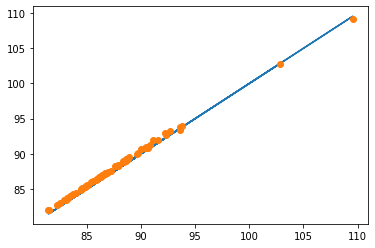

In [13]:
plt.plot(EQFC_ECMS_set, EQFC_ECMS_set)
plt.plot(EQFC_ECMS_set, EQFC_DDPG_set, "o")


